In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('no-Z-Score.csv')
df.describe()

,Age,Word Count CTD,Total Wait Time (s) CTD,Word Count PFT,Total Wait Time (s) PFT,Word Count SFT,Total Wait Time (s) SFT,Converted-MMSE
count,157.00000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,69.000000
mean,65.77707,157.433121,7.917197,32.694268,26.509554,49.292994,18.254777,27.362319
std,12.29634,91.043120,8.103467,15.931610,10.884368,21.727998,9.684712,2.467262
min,23.00000,12.000000,0.000000,8.000000,4.000000,16.000000,1.000000,19.000000
25%,62.00000,90.000000,2.000000,21.000000,18.000000,33.000000,12.000000,27.000000
50%,66.00000,135.000000,5.000000,30.000000,26.000000,45.000000,17.000000,28.000000
75%,72.00000,200.000000,11.000000,41.000000,35.000000,61.000000,24.000000,29.000000
max,94.00000,461.000000,39.000000,89.000000,51.000000,120.000000,46.000000,30.000000


In [3]:
# Überblick über die Datentypen verschaffen
df_info = { "data_types": df.dtypes }
df_info

{'data_types': Record-ID                   object
 TrainOrDev                  object
 Class                       object
 Gender                      object
 Age                        float64
 Word Count CTD             float64
 Total Wait Time (s) CTD    float64
 Word Count PFT             float64
 Total Wait Time (s) PFT    float64
 Word Count SFT             float64
 Total Wait Time (s) SFT    float64
 Converted-MMSE             float64
 dtype: object}

In [4]:
# Numerische Spalten für die Korrelationsanalyse
numeric_columns = df.select_dtypes(include = ['float64']).columns
correlation_matrix = df[numeric_columns].corr()

# Korrelation der numerischen Spalten mit "Converted-MMSE"
mmse_correlation = correlation_matrix['Converted-MMSE'].sort_values(ascending = False)
mmse_correlation

Converted-MMSE             1.000000
Word Count CTD             0.194882
Word Count SFT             0.004747
Total Wait Time (s) PFT   -0.176075
Word Count PFT            -0.231698
Total Wait Time (s) SFT   -0.284651
Age                       -0.335210
Total Wait Time (s) CTD   -0.369492
Name: Converted-MMSE, dtype: float64

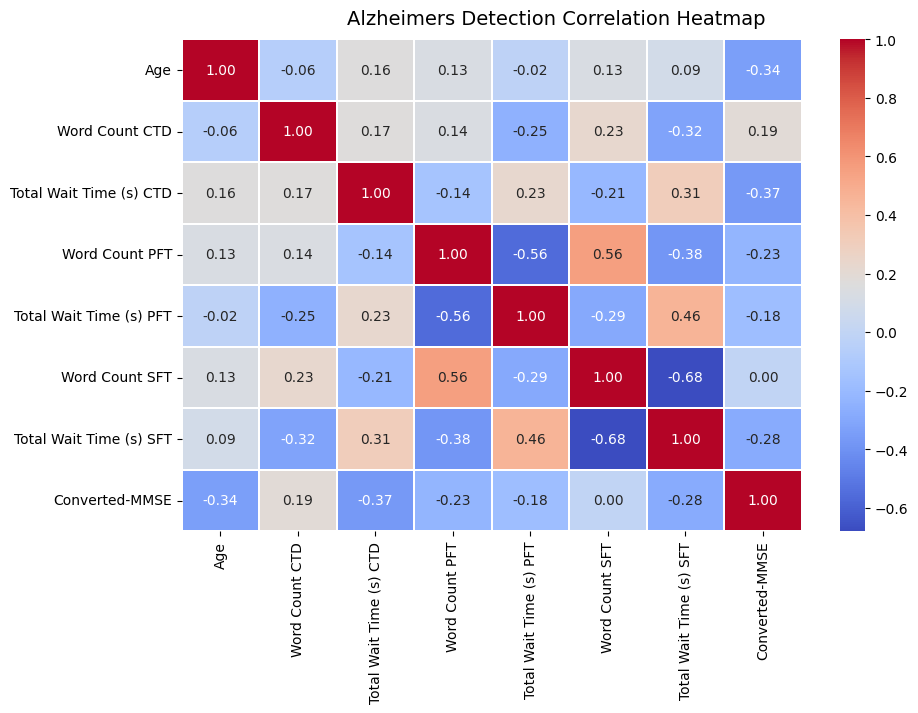

In [5]:
# Pair-wise Correlation Matrix Heatmap
f, ax = plt.subplots(figsize = (10, 6))
corr = df.corr(numeric_only = True)
hm = sns.heatmap(round(corr, 2), annot = True, ax = ax, cmap = "coolwarm", fmt = '.2f', linewidths = .05)
f.subplots_adjust(top = 0.93)
t = f.suptitle('Alzheimers Detection Correlation Heatmap', fontsize = 14)

In [6]:
# Datenvorbereitung
# Merkmale mit signifikanter Korrelation auswählen
features = ['Word Count PFT', 'Total Wait Time (s) PFT', 'Word Count SFT', 'Total Wait Time (s) SFT']

# Daten ohne fehlende Werte (für Modelltraining)
train_data = df.dropna(subset = ['Converted-MMSE'])
X_train = train_data[features]
y_train = train_data['Converted-MMSE']

# Fehlende Werte für Vorhersage
missing_data = df[df['Converted-MMSE'].isnull()]
X_missing = missing_data[features]

# Train-Test-Split (für Modellbewertung)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size = .2, random_state = 42)

# Modelltraining
rf_model = RandomForestRegressor(random_state = 42, n_estimators = 100)
rf_model.fit(X_train_split, y_train_split)

# Modellbewertung
y_pred = rf_model.predict(X_test_split)
rmse = mean_squared_error(y_test_split, y_pred, squared = False)

# Fehlende Werte vorhersagen
missing_predictions = rf_model.predict(X_missing)

# RMSE ausgeben und fehlende Werte imputieren
# Zeigt die RMSE und die ersten 5 Vorhersagen
rmse, missing_predictions[:5]

C:\Users\BenLa\miniconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(1.6387037560218136), array([25.78, 27.67, 27.78, 27.5 , 28.62]))

In [8]:
# Sicherstellen, dass Indizes korrekt sind
missing_indices = df[df['Converted-MMSE'].isnull()].index

# Fehlende Werte durch Vorhersagen ersetzen
df.loc[missing_indices, 'Converted-MMSE'] = missing_predictions.round().astype(int)

<Axes: ylabel='Converted-MMSE'>

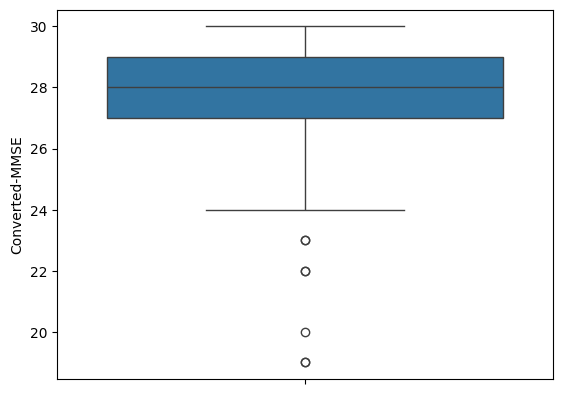

In [9]:
# Boxplot
sns.boxplot(data = df['Converted-MMSE'])

<Axes: ylabel='Converted-MMSE'>

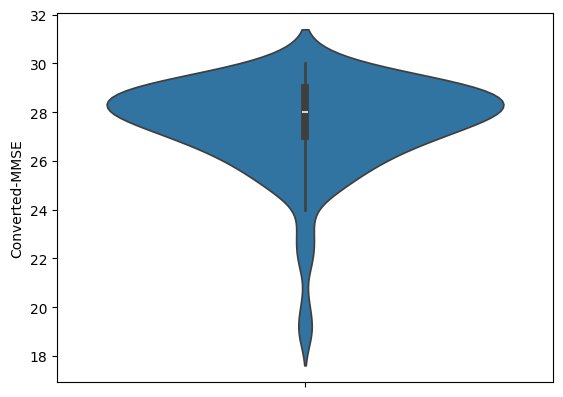

In [11]:
# Violinplot
sns.violinplot(data = df['Converted-MMSE'])

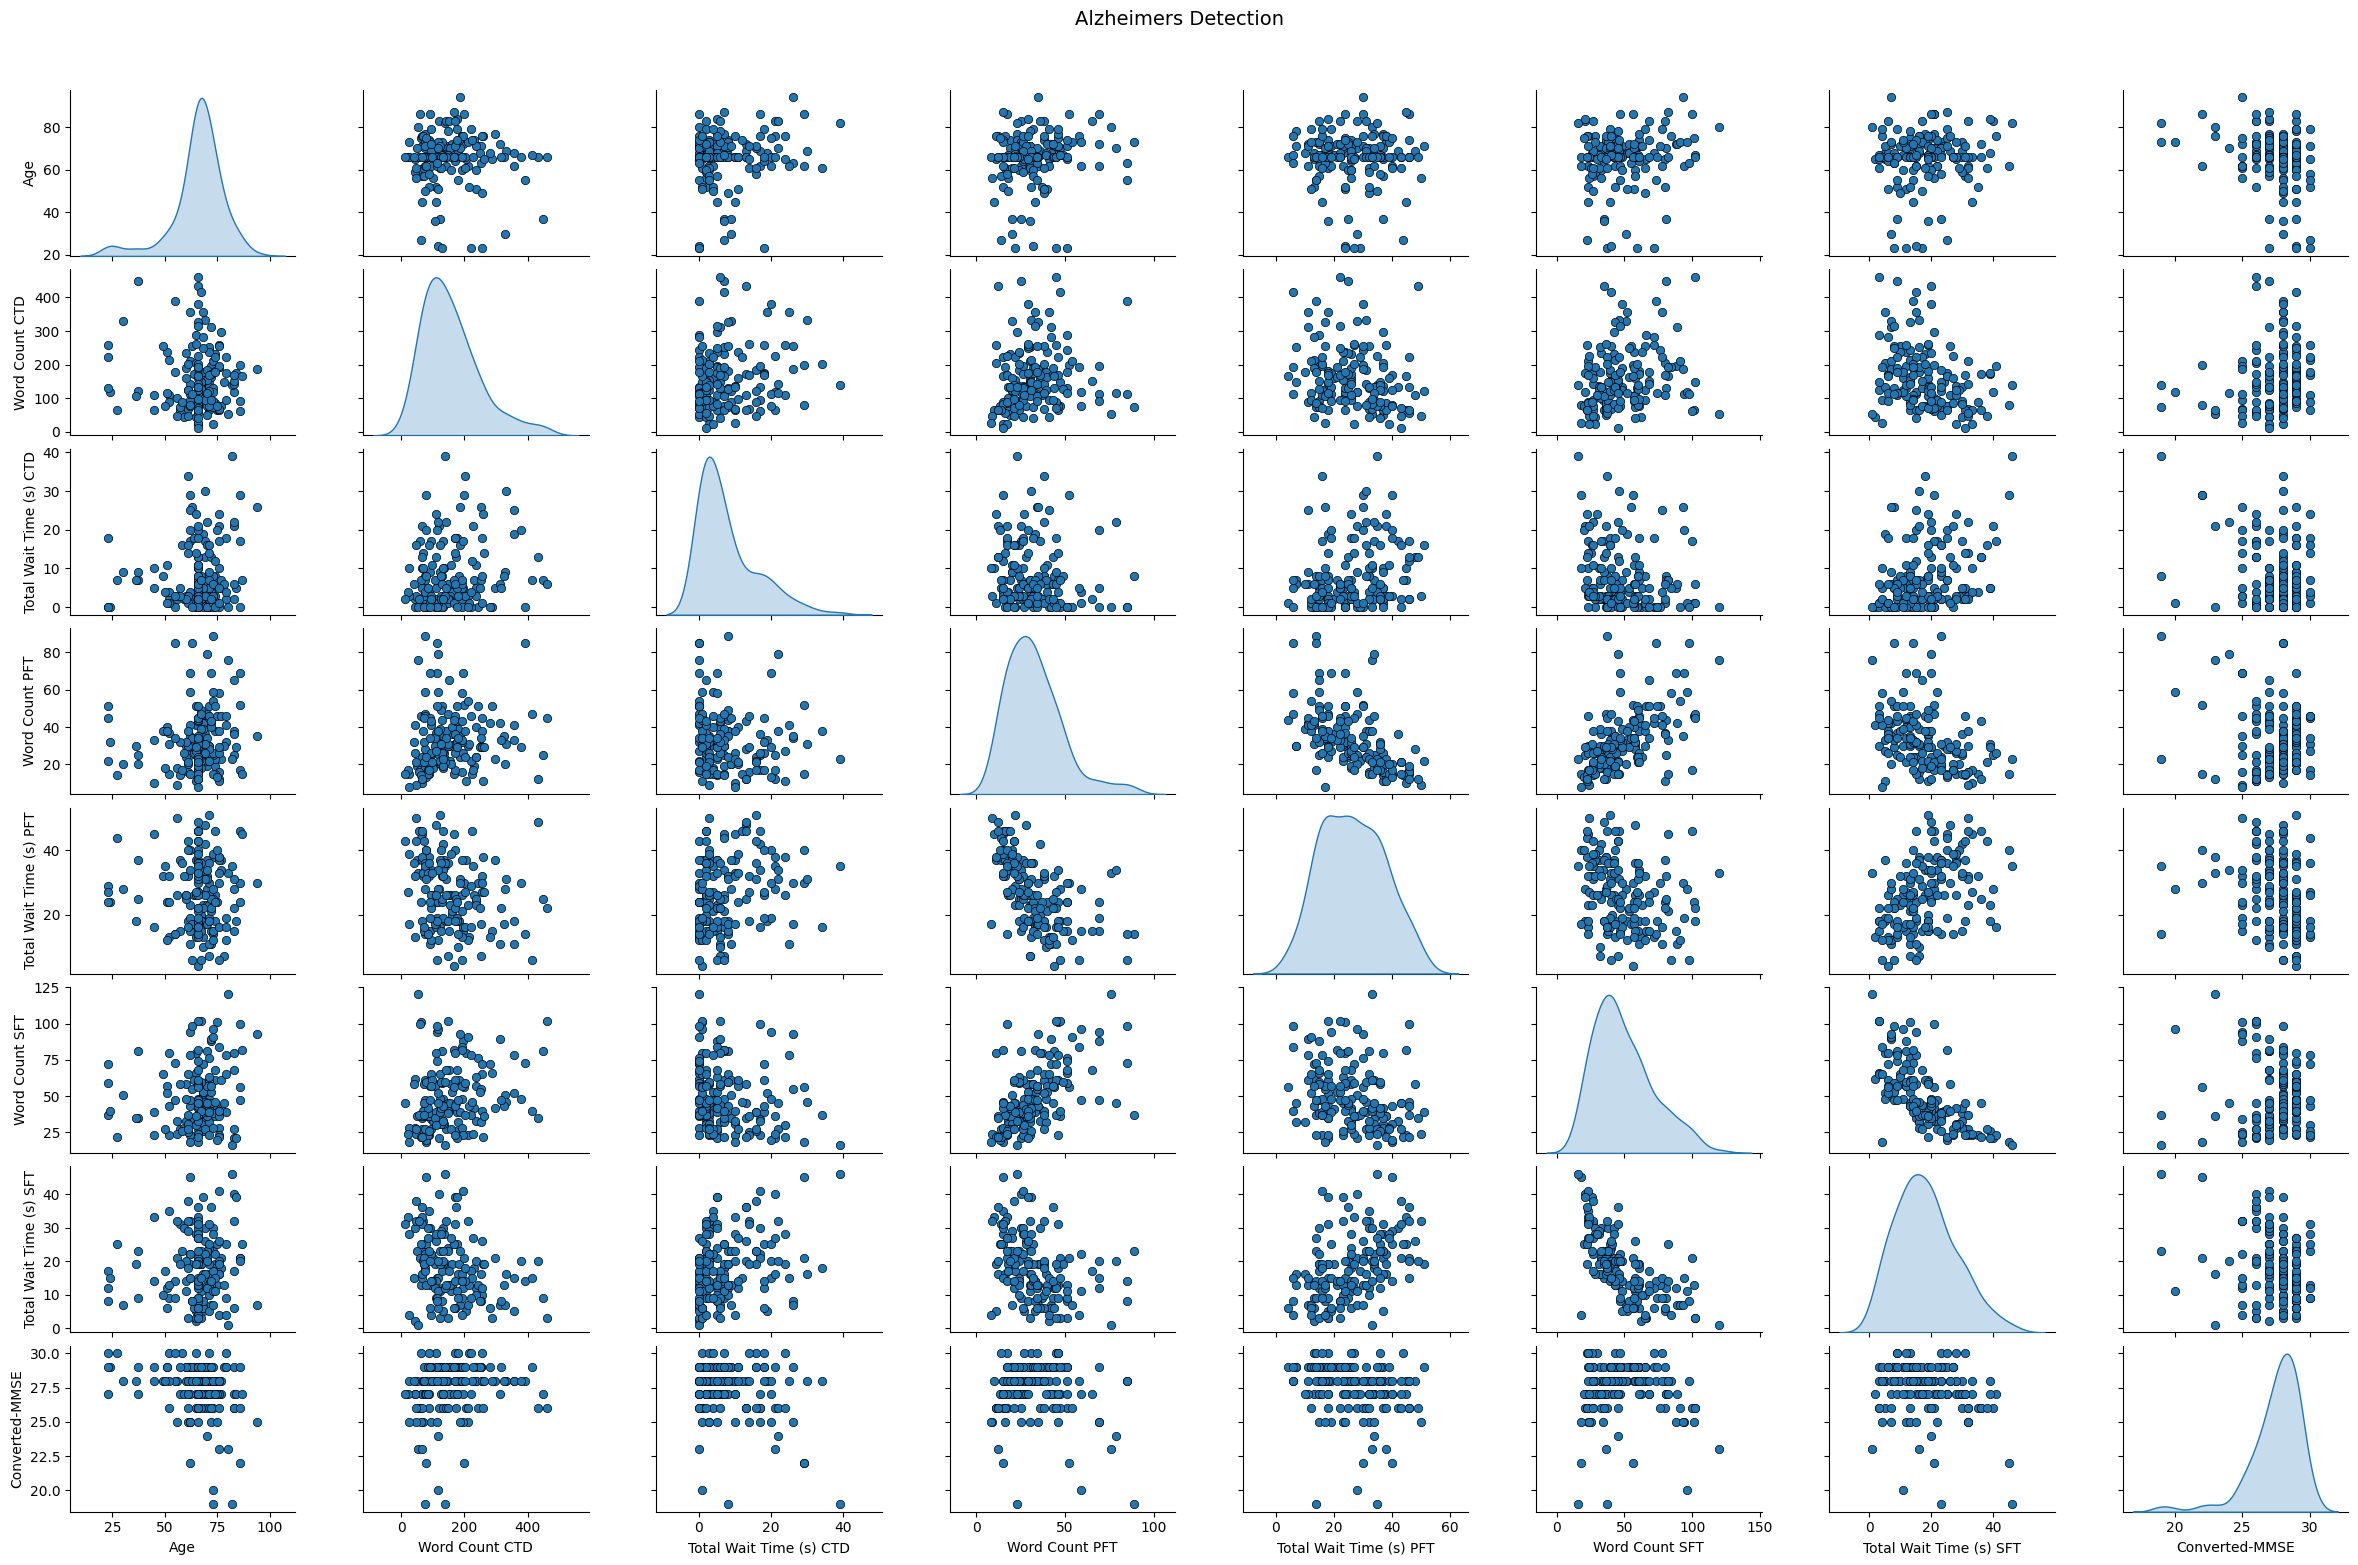

In [12]:
# Pair-wise Scatter Plots
pp = sns.pairplot(df, height = 2, aspect = 1.5, # set height of each facet to 2 inches and width to 2 * 1.5 inches
                  plot_kws = dict(edgecolor = "k", linewidth = .5), # change edges of points to thin black
                  diag_kind = "kde", diag_kws = dict(fill = True)) # set diagonal charts, kws = keyword arguments

fig = pp.fig
fig.subplots_adjust(top = .93, wspace = .3) # increase top space and white spaces between the plots
fig.suptitle('Alzheimers Detection', fontsize = 14); # add title to figure

In [13]:
# Gespeicherte Tabelle mit ausgefüllten Werten
df.to_csv("Filled_mmse-no-Z-Score.csv", index = False)